# Fashion-MNIST classification

In [1]:
import time
from functools import partial

import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
train_set = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist', train=True, download=True)
test_set = torchvision.datasets.FashionMNIST(
    root='../data/fashion-mnist', train=False, download=True)

In [4]:
labels = [
    'top', 'trousers', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

In [5]:
# Print some kind of data sets summary
print(train_set)
print(test_set)

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../data/fashion-mnist
    Transforms (if any): None
    Target Transforms (if any): None
Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../data/fashion-mnist
    Transforms (if any): None
    Target Transforms (if any): None


In [6]:
train_x = np.array(train_set.train_data)
train_y = np.array(train_set.train_labels)

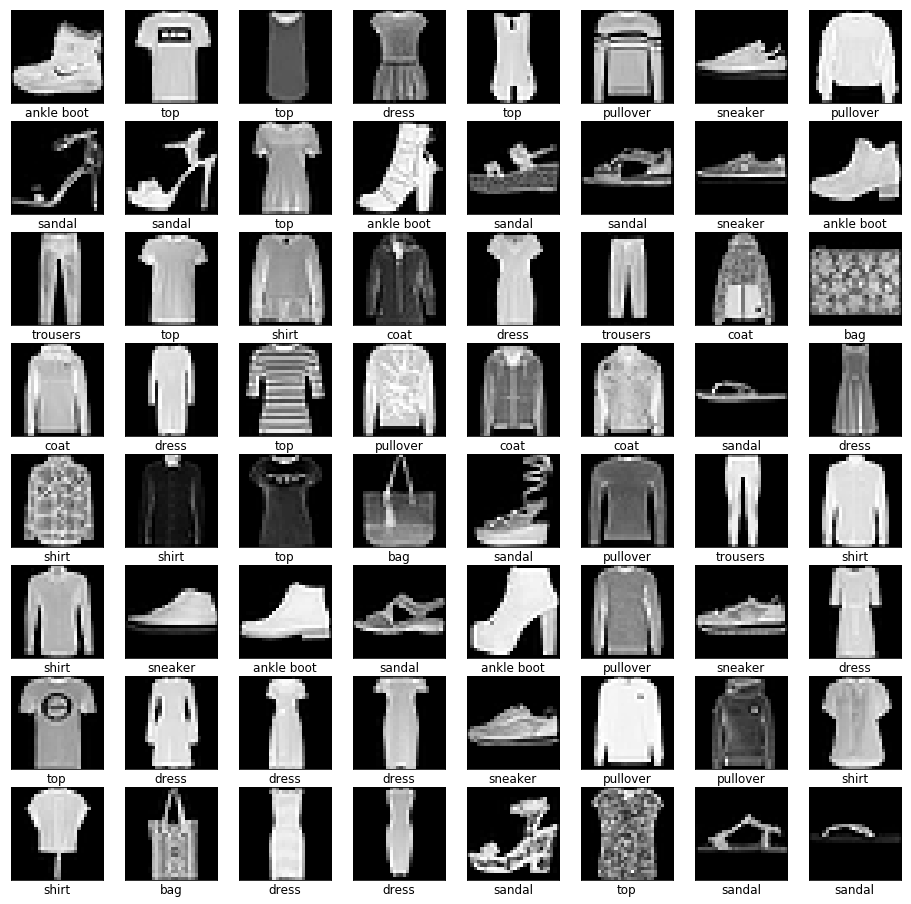

In [7]:
plt.figure(figsize=(16, 16))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.imshow(train_x[i], cmap=plt.cm.gray)
    plt.xlabel(labels[train_y[i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

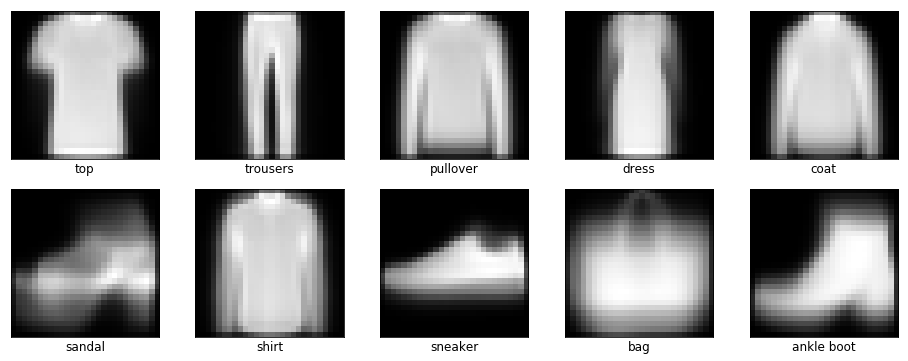

In [8]:
centroids = [(labels[i], np.mean(train_x[train_y == i], axis=0)) for i, _ in enumerate(labels)]

plt.figure(figsize=(16, 6))
for i, (label, image) in enumerate(centroids):
    plt.subplot(2, 5, i + 1)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.xlabel(label)
    plt.xticks([])
    plt.yticks([])
plt.show()

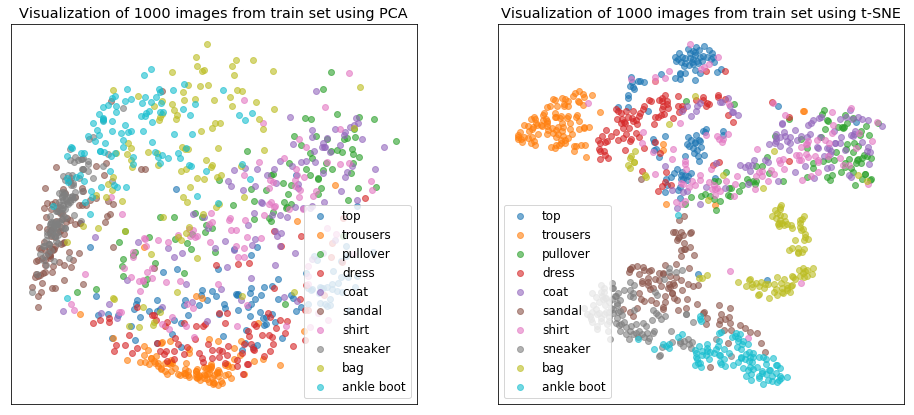

In [9]:
plt.figure(figsize=(16, 7))
for i, (algorithm_name, algorithm) in enumerate([
        ('PCA', PCA(n_components=2)), ('t-SNE', TSNE(n_components=2))]):
    x = algorithm.fit_transform(train_x[:1000].reshape(-1, 784))
    y = train_y[:1000]
    data = [(labels[i], x[y == i]) for i, _ in enumerate(labels)]
    
    plt.subplot(1, 2, i + 1)
    for label, points in data:
        plt.scatter(points[:, 0], points[:, 1], alpha=0.6, label=label)
    plt.title(f'Visualization of 1000 images from train set using {algorithm_name}')
    plt.legend()
    plt.xticks([])
    plt.yticks([])
plt.show()

In [10]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(
        root='../data/fashion-mnist',
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()),
    batch_size=250,
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST(
        root='../data/fashion-mnist',
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()),
    batch_size=250,
    shuffle=True)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [12]:
def accuracy(data_loader):
    correct, total = 0, 0
    model.eval()
    for data, target in data_loader:
        data = data.to(device)
        output = model(data).cpu().argmax(dim=1)
        correct += int((output == target).sum())
        total += output.size()[0]
    return correct / total

In [13]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = torch.nn.ModuleList([
            torch.nn.Dropout(0.25),
            torch.nn.Linear(784, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.25),
            torch.nn.Linear(150, 10),
#             torch.nn.Softmax(dim=1)
        ])
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        for layer in self.layers:
            x = layer(x)
        return x
    
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [14]:
model.train()
for epoch_i in range(50):
    start_time = time.time()
    losses = []
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().data)
    loss = np.mean(np.array(losses))
    duration = time.time() - start_time
    print(f'[{epoch_i+1:2}/50] {duration:4.1f}s - loss: {loss:.4f}')

[ 1/50]  4.1s - loss: 0.7257
[ 2/50]  4.0s - loss: 0.5009
[ 3/50]  4.1s - loss: 0.4567
[ 4/50]  4.1s - loss: 0.4319
[ 5/50]  4.1s - loss: 0.4122
[ 6/50]  4.1s - loss: 0.3999
[ 7/50]  4.1s - loss: 0.3896
[ 8/50]  4.1s - loss: 0.3806
[ 9/50]  4.1s - loss: 0.3746
[10/50]  4.1s - loss: 0.3669
[11/50]  4.1s - loss: 0.3581
[12/50]  4.1s - loss: 0.3526
[13/50]  4.0s - loss: 0.3482
[14/50]  4.1s - loss: 0.3465
[15/50]  4.1s - loss: 0.3397
[16/50]  4.1s - loss: 0.3393
[17/50]  4.1s - loss: 0.3330
[18/50]  4.1s - loss: 0.3335
[19/50]  4.1s - loss: 0.3285
[20/50]  4.1s - loss: 0.3237
[21/50]  4.0s - loss: 0.3247
[22/50]  4.1s - loss: 0.3226
[23/50]  4.1s - loss: 0.3175
[24/50]  4.1s - loss: 0.3159
[25/50]  4.1s - loss: 0.3148
[26/50]  4.0s - loss: 0.3130
[27/50]  4.1s - loss: 0.3110
[28/50]  4.1s - loss: 0.3067
[29/50]  4.1s - loss: 0.3037
[30/50]  4.1s - loss: 0.3064
[31/50]  4.1s - loss: 0.3064
[32/50]  4.1s - loss: 0.3026
[33/50]  4.1s - loss: 0.3012
[34/50]  4.1s - loss: 0.3016
[35/50]  4.1s 

In [15]:
print(f'Train set accuracy: {accuracy(train_loader):.4f}')
print(f'Test set accuracy: {accuracy(test_loader):.4f}')

Train set accuracy: 0.9211
Test set accuracy: 0.8889


In [16]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_layers = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 32, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        ])
        self.dense_layers = torch.nn.ModuleList([
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 150),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(150, 10),
#             torch.nn.Softmax(dim=1),
        ])
    def forward(self, x):
        for layer in self.conv_layers:
            x = layer(x)
        x = x.view(x.size()[0], -1)
        for layer in self.dense_layers:
            x = layer(x)
        return x
    
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters())

In [17]:
model.train()
for epoch_i in range(50):
    start_time = time.time()
    losses = []
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().data)
    loss = np.mean(np.array(losses))
    duration = time.time() - start_time
    print(f'[{epoch_i+1:2}/50] {duration:4.1f}s - loss: {loss:.4f}')

[ 1/50]  6.3s - loss: 0.9134
[ 2/50]  6.2s - loss: 0.5832
[ 3/50]  6.2s - loss: 0.5044
[ 4/50]  6.2s - loss: 0.4540
[ 5/50]  6.2s - loss: 0.4172
[ 6/50]  6.2s - loss: 0.3936
[ 7/50]  6.2s - loss: 0.3726
[ 8/50]  6.2s - loss: 0.3591
[ 9/50]  6.2s - loss: 0.3485
[10/50]  6.2s - loss: 0.3338
[11/50]  6.2s - loss: 0.3226
[12/50]  6.2s - loss: 0.3154
[13/50]  6.2s - loss: 0.3036
[14/50]  6.2s - loss: 0.2978
[15/50]  6.2s - loss: 0.2885
[16/50]  6.2s - loss: 0.2844
[17/50]  6.2s - loss: 0.2762
[18/50]  6.2s - loss: 0.2713
[19/50]  6.2s - loss: 0.2686
[20/50]  6.2s - loss: 0.2654
[21/50]  6.2s - loss: 0.2607
[22/50]  6.2s - loss: 0.2529
[23/50]  6.2s - loss: 0.2508
[24/50]  6.2s - loss: 0.2425
[25/50]  6.0s - loss: 0.2399
[26/50]  6.1s - loss: 0.2424
[27/50]  6.2s - loss: 0.2391
[28/50]  6.2s - loss: 0.2315
[29/50]  6.2s - loss: 0.2263
[30/50]  6.2s - loss: 0.2275
[31/50]  6.2s - loss: 0.2206
[32/50]  6.2s - loss: 0.2201
[33/50]  6.2s - loss: 0.2193
[34/50]  6.2s - loss: 0.2115
[35/50]  6.3s 

In [18]:
print(f'Train set accuracy: {accuracy(train_loader):.4f}')
print(f'Test set accuracy: {accuracy(test_loader):.4f}')

Train set accuracy: 0.9583
Test set accuracy: 0.9118
